In [1]:
import dask.dataframe as dd
from dask import delayed

import re
import pandas as pd
from pandas import Grouper
import numpy as np

from tqdm.notebook import tqdm 
import multiprocessing as mp

import demoji 

from datetime import datetime
from datetime import timedelta
import contractions

import spacy
nlp = spacy.load('en_core_web_sm', disable = ['tok2vec', 'parser', 'ner']) 

from pandarallel import pandarallel
from collections import Counter
from matplotlib import pyplot as plt

from scipy.stats import jarque_bera
from scipy.stats import boxcox

import pylab as pl
from numpy import fft

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.special import inv_boxcox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import jarque_bera

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from adjustText import adjust_text
from statsmodels.tsa.arima.model import ARIMA



Reading in all the CSV's of Elon's tweets

We only want original tweets from Elon, not responses, even to his own threads, but just independently drafted tweets.

In [2]:
df = dd.read_csv('archive/*.csv', 
                 dtype={'thumbnail': 'object', 'quote_url': 'object', 'created_at': 'object'})
#, usecols=['tweet', 'hashtags', 'urls', 'cashtags','reply_to', 'retweet', 'nretweets', 'date'])
#df = df[(df['reply_to'] == '[]') & (df['retweet'] == False)]

df = df.compute()
df.drop(columns = ['Unnamed: 0'], inplace = True)

df.dropna(axis = 'rows', subset = ['nretweets'], inplace = True)

df = df[['tweet', 'hashtags', 'urls', 'cashtags','reply_to', 'nretweets', 'date']]

In [3]:
df['date'] = df.date.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df = df.sort_values(by='date')
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace = True)

In [4]:
df

,tweet,hashtags,urls,cashtags,reply_to,nretweets,date
0,"Please ignore prior tweets, as that was someon...",[],[],[],[],348.0,2010-06-04 18:31:57
1,Went to Iceland on Sat to ride bumper cars on ...,[],[],[],[],15.0,2011-12-01 09:55:11
2,I made the volume on the Model S http://t.co/...,[],['http://ow.ly/i/mtD7'],[],[],9.0,2011-12-01 10:29:04
3,"Great Voltaire quote, arguably better than Twa...",[],[],[],[],25.0,2011-12-03 08:20:28
4,That was a total non sequitur btw,[],[],[],[],6.0,2011-12-03 08:22:07
...,...,...,...,...,...,...,...
13421,@PPathole @WSJ Absolutely,[],[],[],"[{'screen_name': 'PPathole', 'name': 'Pranay P...",92.0,2020-12-28 05:39:42
13422,What should Tesla do with in-car gaming in an ...,[],[],[],[],884.0,2020-12-28 17:23:31
13423,@richierichhhhh_ Absolutely,[],[],[],"[{'screen_name': 'richierichhhhh_', 'name': 'R...",907.0,2020-12-28 17:23:51
13424,@kimpaquette Just meeting with Larry Ellison t...,[],[],[],"[{'screen_name': 'kimpaquette', 'name': 'Kim P...",314.0,2020-12-28 18:07:33


In [5]:
initial_day = datetime.strptime('2018-01-01', '%Y-%m-%d')

date_ranges = []

for step, x in enumerate(range(1,365)):
    date_ranges.append((initial_day + timedelta(days=1*(x-1)), initial_day + timedelta(days=1*x)))

for step, (start, end) in enumerate(date_ranges):
    samples = df[(df.date >= start) & (df.date < end)].shape[0]
    print(f'There are {samples} tweets on {start:%Y-%m-%d}')

There are 0 tweets on 2018-01-01
There are 0 tweets on 2018-01-02
There are 4 tweets on 2018-01-03
There are 0 tweets on 2018-01-04
There are 4 tweets on 2018-01-05
There are 0 tweets on 2018-01-06
There are 8 tweets on 2018-01-07
There are 2 tweets on 2018-01-08
There are 4 tweets on 2018-01-09
There are 0 tweets on 2018-01-10
There are 0 tweets on 2018-01-11
There are 2 tweets on 2018-01-12
There are 2 tweets on 2018-01-13
There are 0 tweets on 2018-01-14
There are 2 tweets on 2018-01-15
There are 0 tweets on 2018-01-16
There are 0 tweets on 2018-01-17
There are 2 tweets on 2018-01-18
There are 0 tweets on 2018-01-19
There are 0 tweets on 2018-01-20
There are 0 tweets on 2018-01-21
There are 0 tweets on 2018-01-22
There are 0 tweets on 2018-01-23
There are 2 tweets on 2018-01-24
There are 0 tweets on 2018-01-25
There are 0 tweets on 2018-01-26
There are 2 tweets on 2018-01-27
There are 27 tweets on 2018-01-28
There are 14 tweets on 2018-01-29
There are 2 tweets on 2018-01-30
There ar

There are 0 tweets on 2018-09-30
There are 2 tweets on 2018-10-01
There are 4 tweets on 2018-10-02
There are 0 tweets on 2018-10-03
There are 26 tweets on 2018-10-04
There are 26 tweets on 2018-10-05
There are 13 tweets on 2018-10-06
There are 2 tweets on 2018-10-07
There are 10 tweets on 2018-10-08
There are 12 tweets on 2018-10-09
There are 6 tweets on 2018-10-10
There are 4 tweets on 2018-10-11
There are 14 tweets on 2018-10-12
There are 9 tweets on 2018-10-13
There are 14 tweets on 2018-10-14
There are 16 tweets on 2018-10-15
There are 10 tweets on 2018-10-16
There are 12 tweets on 2018-10-17
There are 19 tweets on 2018-10-18
There are 13 tweets on 2018-10-19
There are 17 tweets on 2018-10-20
There are 11 tweets on 2018-10-21
There are 31 tweets on 2018-10-22
There are 15 tweets on 2018-10-23
There are 0 tweets on 2018-10-24
There are 37 tweets on 2018-10-25
There are 29 tweets on 2018-10-26
There are 45 tweets on 2018-10-27
There are 0 tweets on 2018-10-28
There are 6 tweets on 20

As we can see, this is an unevenly spaced time series. One we can deal with this is by descritizing the time series into weekly buckets. This will lead to data loss however. Thus, we'll reframe our problem to deal with time series that can predict the highest-retweeted tweet in a given week, given those of previous weeks. 

In [6]:
new_df = []
date_ranges = []

range_ = []
for x in tqdm(range(19,21)):
    
    date_ranges = []
    initial_day = datetime.strptime(f'20{x}-01-01', '%Y-%m-%d')

    for step, x in enumerate(range(1,53)):
        date_ranges.append((initial_day + timedelta(days=7*(x-1)), initial_day + timedelta(days=7*x)))

    for step, (start, end) in enumerate(date_ranges):
        range_.append(df[(df.date >= start) & (df.date < end)].shape[0])
        #new_df.append([x for x in df[(df.date >= start) & (df.date < end)].nlargest(5, 'nretweets').values.flatten().tolist()])


    

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
new_df = []
date_ranges = []
for x in tqdm(range(19,21)):
    
    date_ranges = []
    initial_day = datetime.strptime(f'20{x}-01-01', '%Y-%m-%d')

    for step, x in enumerate(range(1,53)):
        date_ranges.append((initial_day + timedelta(days=7*(x-1)), initial_day + timedelta(days=7*x)))

    for step, (start, end) in enumerate(date_ranges):
        for x in df[(df.date >= start) & (df.date < end)].nlargest(14, 'nretweets').sort_values(by='date').values:
            new_df.append(x.tolist())
        #new_df.append([x for x in df[(df.date >= start) & (df.date < end)].nlargest(5, 'nretweets').values.flatten().tolist()])


    

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
new_df = pd.DataFrame(new_df, columns=df.columns)
new_df.set_index('date', drop=True, inplace = True)
df = new_df

But first, we'll start looking at the time series from 2019-01-01 onwards. 

  0%|          | 0/2 [00:00<?, ?it/s]

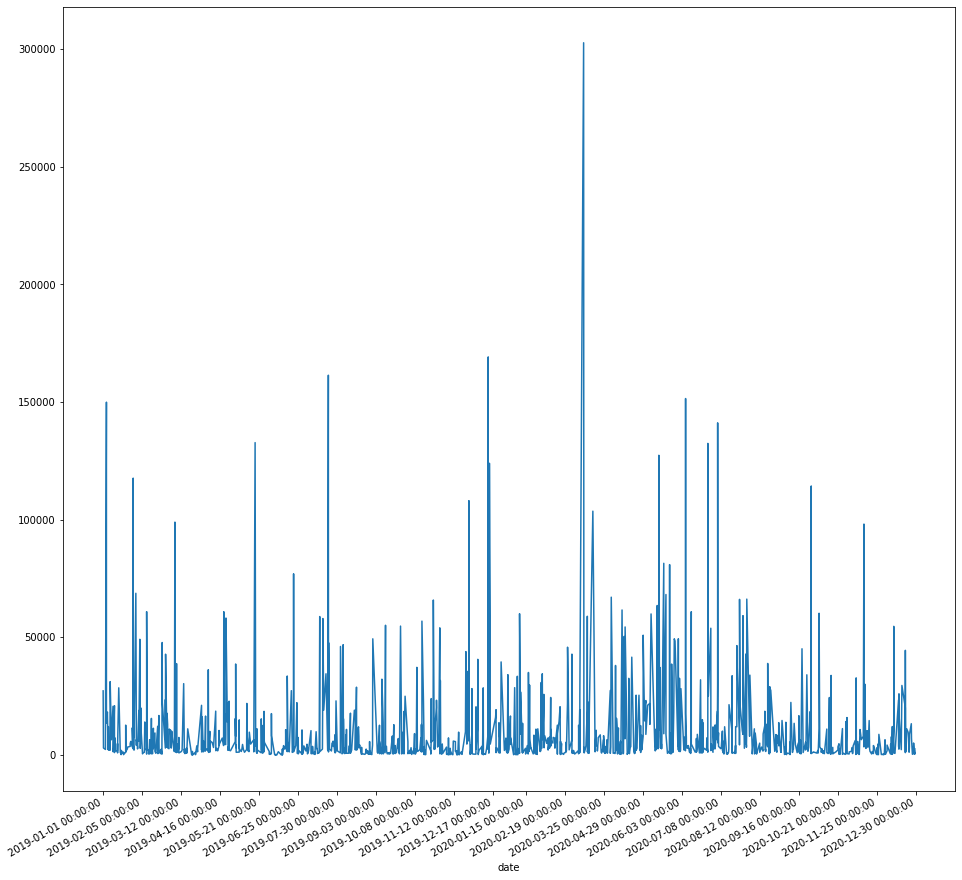

In [9]:
date_ranges = []
for x in tqdm(range(19,21)):
    initial_day = datetime.strptime(f'20{x}-01-01', '%Y-%m-%d')

    for step, x in enumerate(range(53)):
        date_ranges.append(initial_day + timedelta(days=7*(x)))
        

fig, ax = plt.subplots(figsize=(16,16))
df.nretweets.plot()
plt.xticks(date_ranges[::5], list(map(lambda x: str(x), date_ranges[::5]))) #,df.index)
plt.show()

(array([0.84261168, 0.11546392, 0.02886598, 0.01305842]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

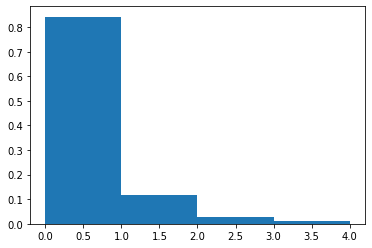

In [10]:
differences = []

for x, y in zip(df.index[1:], df.index[:-1]):
    differences.append( (x - y).days )
    
plt.hist(differences, bins=list(range(5)), density = True)

We can see approximately 80% of the top 14 tweets within any given week fall on the same day.
In order to account for the uneven time intervals, we will simply standardize date to be the start of the week, and incrementally add two dates at pre-determined time intervals for all top 14 tweets within the week. Given that 80% are within the same day, this does little but unroll the data using dummy time stamps. 

In [11]:
df

,tweet,hashtags,urls,cashtags,reply_to,nretweets
date,,,,,,
2019-01-01 00:20:48,Haha,[],[],[],[],27252.0
2019-01-01 07:17:51,Congratulations @Tesla team!! https://t.co/PB...,[],[],[],[],2957.0
2019-01-03 01:25:02,Great work by Tesla Team!,[],[],[],[],2355.0
2019-01-03 23:04:15,There are no coincidences https://t.co/9AEbbu...,[],[],[],[],149975.0
2019-01-03 23:06:17,"Evian, the first bottled water, is naive spell...",[],[],[],[],13537.0
...,...,...,...,...,...,...
2020-12-27 22:18:58,Try playing Polytopia in your Tesla! Great gam...,[],[],[],[],4186.0
2020-12-28 17:23:31,What should Tesla do with in-car gaming in an ...,[],[],[],[],884.0
2020-12-28 17:23:51,@richierichhhhh_ Absolutely,[],[],[],"[{'screen_name': 'richierichhhhh_', 'name': 'R...",907.0


In [12]:
datelist = pd.date_range(start = datetime.strptime(f'2019-01-01', '%Y-%m-%d'), freq = '12H',
                         periods=208 * 7).tolist()

In [13]:
df.index = datelist

In [14]:
df

,tweet,hashtags,urls,cashtags,reply_to,nretweets
2019-01-01 00:00:00,Haha,[],[],[],[],27252.0
2019-01-01 12:00:00,Congratulations @Tesla team!! https://t.co/PB...,[],[],[],[],2957.0
2019-01-02 00:00:00,Great work by Tesla Team!,[],[],[],[],2355.0
2019-01-02 12:00:00,There are no coincidences https://t.co/9AEbbu...,[],[],[],[],149975.0
2019-01-03 00:00:00,"Evian, the first bottled water, is naive spell...",[],[],[],[],13537.0
...,...,...,...,...,...,...
2020-12-26 12:00:00,Try playing Polytopia in your Tesla! Great gam...,[],[],[],[],4186.0
2020-12-27 00:00:00,What should Tesla do with in-car gaming in an ...,[],[],[],[],884.0
2020-12-27 12:00:00,@richierichhhhh_ Absolutely,[],[],[],"[{'screen_name': 'richierichhhhh_', 'name': 'R...",907.0
2020-12-28 00:00:00,@kimpaquette Just meeting with Larry Ellison t...,[],[],[],"[{'screen_name': 'kimpaquette', 'name': 'Kim P...",314.0


In [15]:
def reply_to_bool(str_):
    if str_ == '[]':
        return 0
    return 1

df['reply_to'] = df['reply_to'].map(lambda x: reply_to_bool(x))
df['cashtags'] = df['cashtags'].map(lambda x: reply_to_bool(x))
df['urls'] = df['urls'].map(lambda x: reply_to_bool(x))
df['hashtags'] = df['hashtags'].map(lambda x: reply_to_bool(x))

# removing url links
re1 = r'https?:\/\/\S+'
re2 = r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)"

# removing embedded links, videos, already included in meta_data
re3 = r'{link}'
re4 = r"\[video\]"

# removing usermentions, it is uniformly distributed and does not matter
re5 = r"@([a-zA-Z0-9_]{1,50})"

# removing individual numbers seperated by spaces
re6 = r'\s+\d+\s+'

parser = re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6))

def preprocess_text(input_text):
    
    input_text = re.sub(parser, '', input_text.lower())
    
    # remove emoji symbols, expand contractions
    input_text =  ' '.join([contractions.fix(demoji.replace_with_desc(x)) for x in input_text.split()])
    
    input_text = ' '.join([token.lemma_ for token in nlp(input_text)])
    
    return input_text

pandarallel.initialize(progress_bar=True)
df['tweet']  = df['tweet'].parallel_apply(lambda x: preprocess_text(x))

# removing duplicate indices
df = df[~df.index.duplicated()]

# remove empty strings, or strings with just 1 word
df = df[df['tweet'].str.split().str.len() > 1]
df.sort_index(inplace = True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Creating our train and test sets

In [16]:
df

,tweet,hashtags,urls,cashtags,reply_to,nretweets
2019-01-01 12:00:00,congratulations team ! !,0,0,0,0,2957.0
2019-01-02 00:00:00,great work by tesla team !,0,0,0,0,2355.0
2019-01-02 12:00:00,there are no coincidences,0,0,0,0,149975.0
2019-01-03 00:00:00,"evian , the first bottled water , is naive spe...",0,0,0,0,13537.0
2019-01-04 00:00:00,about a month away from the first orbital test...,0,0,0,0,4536.0
...,...,...,...,...,...,...
2020-12-26 00:00:00,focus on making products & amp ; services peop...,0,0,0,1,5085.0
2020-12-26 12:00:00,try playing polytopia in your tesla ! great ga...,0,0,0,0,4186.0
2020-12-27 00:00:00,what should tesla do with in - car gaming in a...,0,0,0,0,884.0
2020-12-28 00:00:00,just meeting with larry ellison to seek some a...,0,0,0,1,314.0


In [17]:
1125/1330

0.8458646616541353

In [17]:
X_train, Y_train = df.iloc[:1125, :-1], df.iloc[:1125].nretweets

X_test, Y_test = df.iloc[1125:, :-1], df.iloc[1125:].nretweets

In [18]:
Y_train.to_frame().to_csv('retweets.csv')

In [19]:
np.max(X_train['tweet'].str.split().str.len().values)

68

In [20]:
vocab_without_infrequent = set()

words = Counter(X_train.tweet.str.split().explode().values.tolist())

for k,v in dict(words).items():
    if v > 1: 
        vocab_without_infrequent.add(k)

In [21]:
#treating one tweet as a sentence
def create_sequences(dataset_split_sample, seq_length, vocab_):
    temp = ['<s>'] + [x if x in vocab_ else 'UNK' for x in dataset_split_sample.split()]
    temp += ['PAD'] * ( seq_length -1 - len(temp))
    return temp + ['</s>']

def int2token_embedding_train(train_vocab):
    int2token = {}
    int2token['<s>'] = 0
    int2token['</s>'] = 1
    int2token['PAD'] = 2
    int2token['UNK'] = 3
    
    for step, x in enumerate(train_vocab, start = 4):
        int2token[x] = step
    # create token-to-integer mapping
    token2int = {t: i for i, t in int2token.items()}
    return int2token, token2int

def create_embedding(dataset, seq_length, embedding):
    dataset_to_int = np.zeros((len(dataset), seq_length), dtype = np.int64)
    
    for step, x in enumerate(dataset): 
        dataset_to_int[step] = [embedding[word] for word in x]
        
    return dataset_to_int

In [22]:
pandarallel.initialize(progress_bar=True)
padded_train = X_train.tweet.parallel_map(lambda x: create_sequences(x, 100, vocab_without_infrequent))
padded_test = X_test.tweet.parallel_map(lambda x: create_sequences(x, 100, vocab_without_infrequent))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [23]:
token2int, int2token = int2token_embedding_train(vocab_without_infrequent)

In [24]:
X_train_input = create_embedding(padded_train.values, 100, token2int)
X_test_input = create_embedding(padded_test.values, 100, token2int)

X_train_meta = X_train.iloc[:, 1:]
X_test_meta = X_test.iloc[:, 1:]

In [25]:
X_test_input.shape

(205, 100)

In [26]:
X_train_input.shape

(1125, 100)

In [694]:
1125 + 205

1330

Now that we have succesfully preprocessed the data and have everything ready, we will now focus on building the ARIMA model. 

Now we'll carry out a classical decomposition of the time series

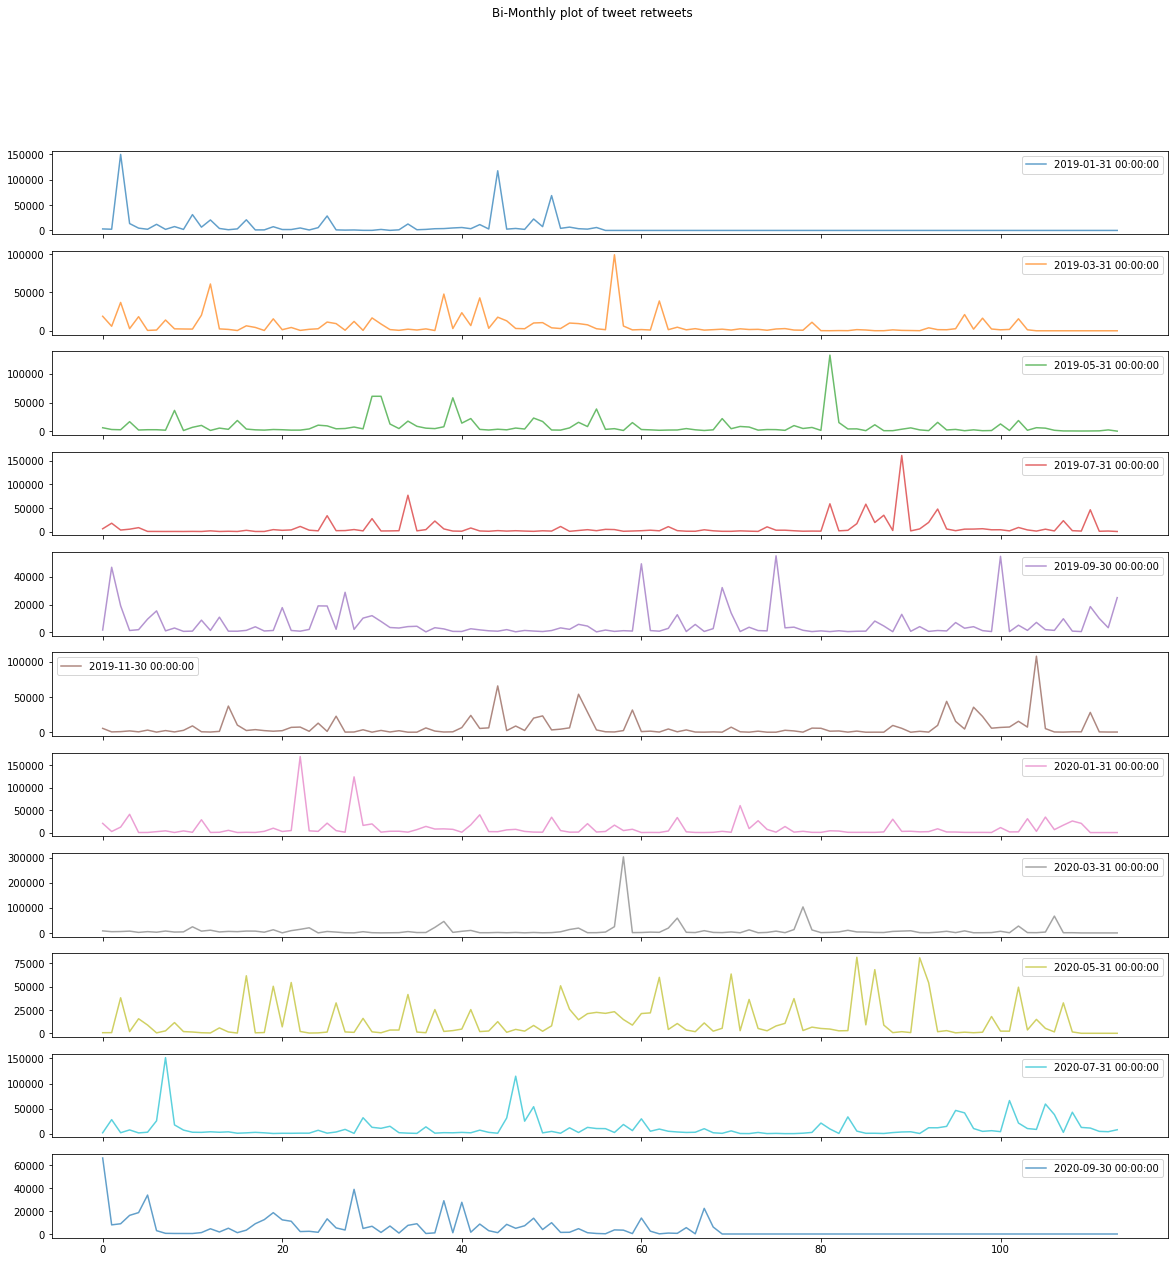

In [27]:
frequency=114
groups = Y_train.to_frame().groupby(Grouper(freq='2M'))
weeks = pd.DataFrame(index = list(range(frequency)), columns = [name for name, group in groups])
temp = []
for name, group in groups:
    if len((y := group.values.flatten().tolist())) < frequency: 
        y += [0]*(frequency - len(y))
    weeks[name.strftime('%Y-%m-%d')] = y

weeks.plot(alpha = .7, subplots=True, legend=True, figsize=(20, 20), title = 'Bi-Monthly plot of tweet retweets')
plt.show()

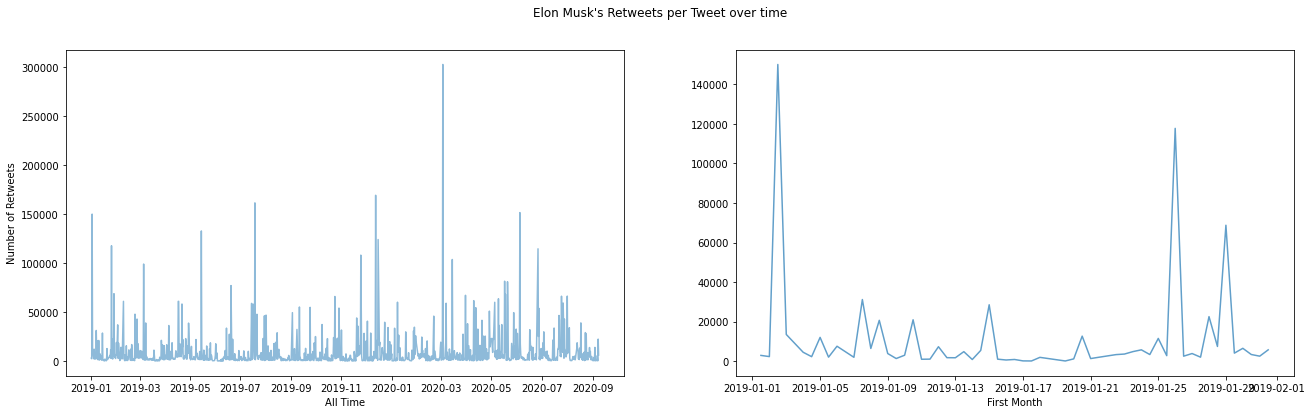

In [28]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[22,6])
fig.suptitle("Elon Musk's Retweets per Tweet over time")
ax1.set_ylabel('Number of Retweets')

ax1.set_xlabel('All Time')
ax2.set_xlabel('First Month')

for x in Y_train.to_frame().groupby(Grouper(freq='M')):
    _, first_month = x
    break

ax1.plot(Y_train, alpha = .5)
ax2.plot(first_month, alpha = .7)

plt.show()

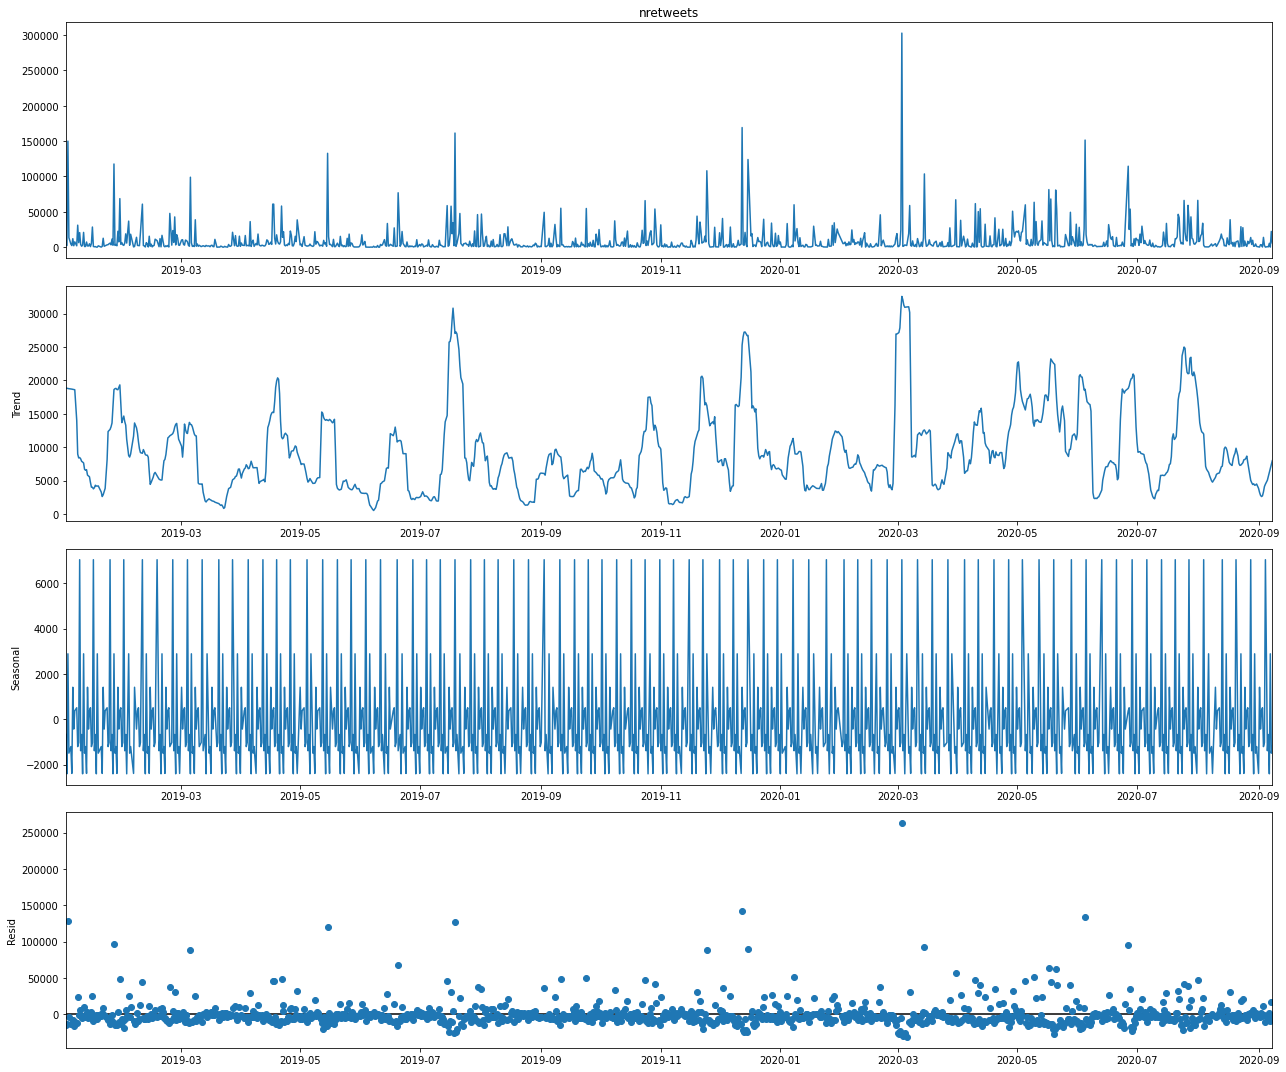

In [32]:
def plot_decomposition(time_series, ret = False, plot = True):
    decomposition = seasonal_decompose(time_series, model='additive', period=14, extrapolate_trend = True)
    if plot == True: 
        plt.rcParams['figure.figsize'] = [18, 15]
        decomposition.plot()
        plt.show()
    if ret == True: 
        return decomposition
    
plot_decomposition(Y_train)

We can first note the heteroscedasticity of the data. 

We will use box-cox to stabilize the variance first. 

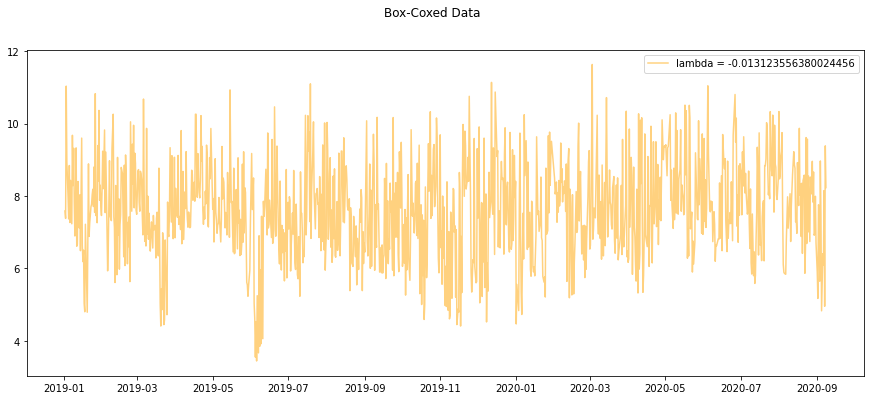

In [34]:
fig, ax = plt.subplots(figsize=[15,6])

Y_train_new = Y_train.copy().to_frame()
Y_train_new.nretweets, lambda_ = boxcox(Y_train.values)

fig.suptitle("Box-Coxed Data")
ax1.set_ylabel('Number of Retweets')
ax1.set_xlabel('All Time')

ax.plot(Y_train_new.nretweets, color = 'orange', alpha = .5, label = f'lambda = {lambda_}')
ax.legend()
plt.show()

Now that we have stabilized the variance, we can carry out our classical time series decomposition.

I have explained the intution behind the model below. 

We see that there is a linear positive trend in the decomposition, so we will difference once to try to make the mean constant. 

We have succesfully eliminated the trend using a difference of order 1. 

We can note there is a clear positive trend, we will difference once to try to account for it. 

As we can see, because both lie on the unit circle, we have that it is essentially a random walk. 

How can we model such a time series then? 

Well, we can use a hybrid ARIMA-LSTM model. 

source: https://reader.elsevier.com/reader/sd/pii/S1568494614002555?token=E415FD5A214240FE0E5247A2192BDD394FB2EF0BD0FC4BC13D89331ECE84DA022A44AA86A8B7C55FC46A6C58AE96DFCB&originRegion=us-east-1&originCreation=20220501005243

Let's first make 2 simple observations. 

1) ARIMA sequence error terms is gaussian or white noise normally distributed by design. 

2) A gaussian time series {y_t} represented as a vector {y_1, ... , y_t} is nothing but a multivariate gaussian vector.

## Intution

From 2, we have that a stationary gaussian time series implies that it is strictly stationary. 

As the authors continue to note: if we then have that a time series is strictly stationary, one possibility is that it is a gaussian time series. 

Further, a common method for estimating parameters of a time series once making it stationary, is using Maximum Likelihood Error, solving for the error term; hence using a gaussian likelihood. 

source: https://mfe.baruch.cuny.edu/wp-content/uploads/2014/12/TS_Lecture1_2019.pdf

Therefore, under this methodology, if it were in fact the case that the time series is gaussian, would lead to a better fit. 

Quoting from the authors: "So, it can be concluded that if the time series is stationary
in the strict sense, an ARIMA model is more suitable for Gaussian
time series data."

## Proposed composition of data

In order to test whether a process is gaussian or not, we can use the Jarque–Bera normality test, concluding it is gaussian the closer it is to 3. 

With the time series have a Jarque–Bera normality test of 3, we would have that the time series is low volatility, gaussian, and therefore a stationary and linear process that could best be modeled by ARIMA. 

Thus, we can say that a time series inherently comprises two parts: 
1) A low volatility component
2) A high volatility component 

Thus, we say that a time series $y_t$ can be modeled as: 

$y_t = \ell_t + h_t$, where $\ell_t$, $h_t$ denote the low and high volatility components respectively. 

## Methodology

The question then becomes how do we seperate the low and high volatility/frequencies of the time series data?

We can do so using an MA moving average filter, as this is exactly purposed to 'discard' the high frequency component of the time series data and only retain the 'smooth' or low frequency aspect. 

For the purpose of this model, and as stated in the paper, we hereby consider a kur-
tosis value of 3, i.e. a gaussian distribution, to be low volatility, and else high volatility. 

## The Hybrid ARIMA-LSTM Model

Now that we've established that we can use a moving average filter to convert our time series into a low volitility gaussian distributed series, we can use ARIMA to estimate this time series and its parameters. 

Formally, 

let $\hat{\ell_t}$ denote the estimated linear component such that: 

$\hat{\ell_t} = f(\ell_{t-1}, \ell_{t-2}, ... , \ell_{t-p}, e_t, e_{t-1}, ..., e_{t})$, 

where $\ell_t$ denotes a realization of the linear component the time series, $e_t$, its realized error terms, and f a linear function. 


Further, let $\hat{h_t}$ denote the estimated non-linear component of the series such that: 

$\hat{h_t} = g(h_{t-1}, h_{t-2}, ... , h_{t-p}) + \epsilon_t$, where $h_{t-1}, h_{t-2}, ... , h_{t-p}$ denotes previous realizations of the non-linear component of the time series, $\epsilon_t$ the model's error, and $g$ the non-linear function. 

Then, letting $X_t$ denote our original time series data, $2q + 1$, to to be our moving average order ,for $q \in \mathbb{Z}^*$, 

We have that:

$\ell_{t} = \frac{1}{2q + 1} \sum_{i =-q}^{q} X_{t+i}$, $  q +1\leq t \leq n-q$.

Giving us that, 

$h_t = X_t - \ell_{t}$.

Finally, taking $f$ to be an ARIMA model, and $g$ to be our LSTM neural network, we have our hybrid ARIMA-LSTM model!


## Implementation

Since the data is non-linear, we will perform two a moving average smoothing and  the Holtz-Winters exponential smoothing. We seek to find one that converges Jarque Bera normality to 3 test while maintaining high confidence levels, per the reasoning above. 

MA smoothing

In [48]:
decomposed = plot_decomposition(Y_train_new.nretweets, ret = True, plot = False)

<AxesSubplot:>

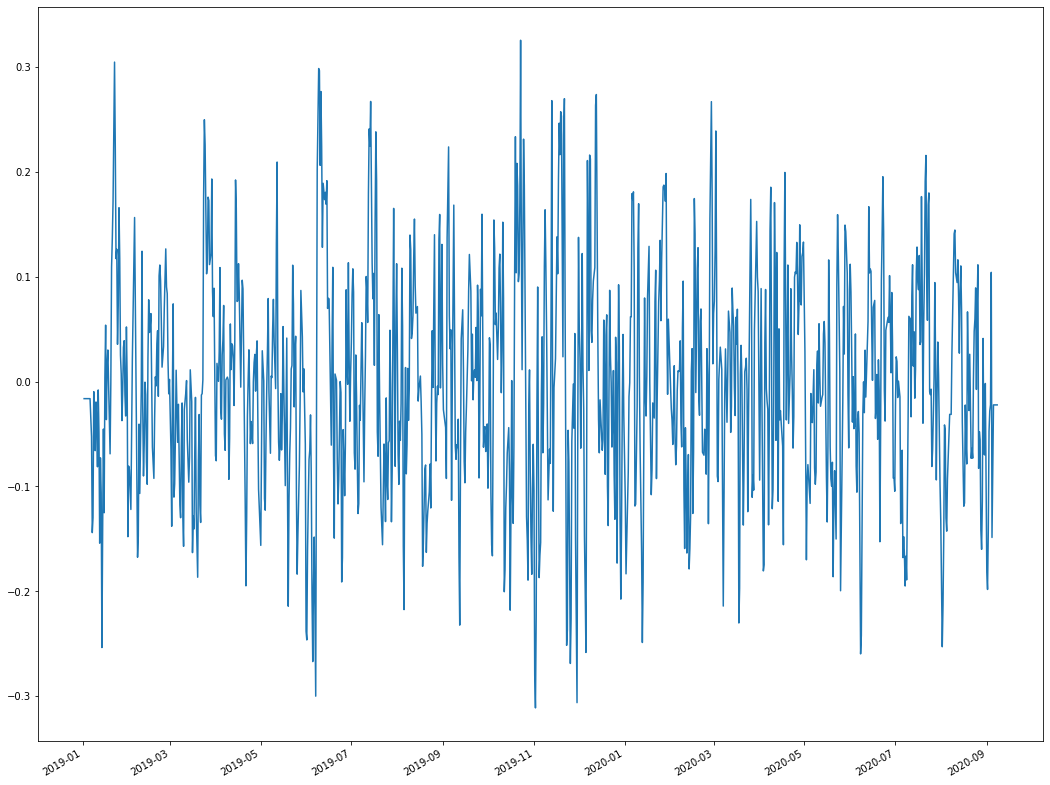

In [52]:
decomposed.trend.diff().dropna().plot()

To add back seasonality and trend for forecasts, we will model them using fourrier transforms. 

In [43]:
def fourierExtrapolation(x, n_predict, n_harm_ = 0):
    n = x.size
    if n_harm_ == 0: 
        n_harm = int(x.size/2)       # number of harmonics in model
    else: 
        n_harm = n_harm_
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

def plot_fourrier(extrapolation, x, axis, title):
    axis.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = f'{title} extrapolation')
    axis.plot(np.arange(0, x.size), x, 'b', label = title, alpha = .2, linewidth = 3)
    axis.legend()

In [61]:
def add_trend_seasonality():
    return decomposed.seasonal + pd.Series(trend, index = decomposed.seasonal.index)

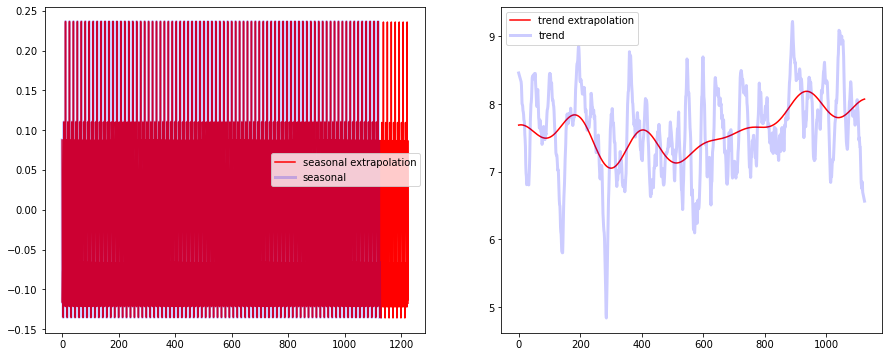

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))
plot_fourrier(seasonal, decomposed.seasonal.values, ax1, 'seasonal')
plot_fourrier(trend, decomposed.trend, ax2, 'trend')

plt.show()

In [56]:
seasonal = fourierExtrapolation(decomposed.seasonal, 100)
trend = fourierExtrapolation(decomposed.trend, 0, 6)

In [59]:
MA_train = plot_decomposition(Y_train_new.nretweets[:1000], ret = True, plot = False)

MA_valid = plot_decomposition(Y_train_new.nretweets[1000:], ret = True, plot = False)

To make sure we do not overfit, we will hold out a validation set and take the RMSE of the fourrier transforms for different function amounts. 

The seasonal component seems fixed, so this may only be necssary for the trend. 


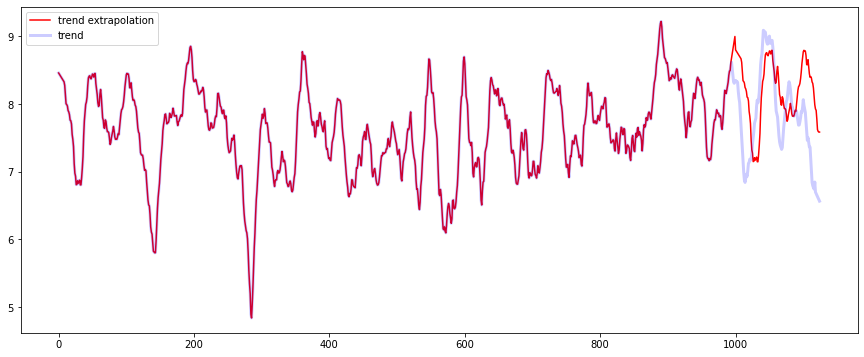

In [60]:
fig, ax = plt.subplots(figsize = (15,6))

trend_train = fourierExtrapolation(MA_train.trend, n_predict = 125)
plot_fourrier(trend_train, decomposed.trend, ax, 'trend')

plt.show()

In [257]:
maes, rmaes, mapes = [], [], []
for x in tqdm(range(1, int(decomposed.trend.size/2))):
    trend_train = fourierExtrapolation(MA_train.trend, n_predict = 125, n_harm_ = x)
    mae, rmae, mape = return_all_tests(trend_train[1000:], decomposed.trend[1000:].values)
    maes.append(mae)
    rmaes.append(rmae)
    mapes.append(mape)

  0%|          | 0/561 [00:00<?, ?it/s]

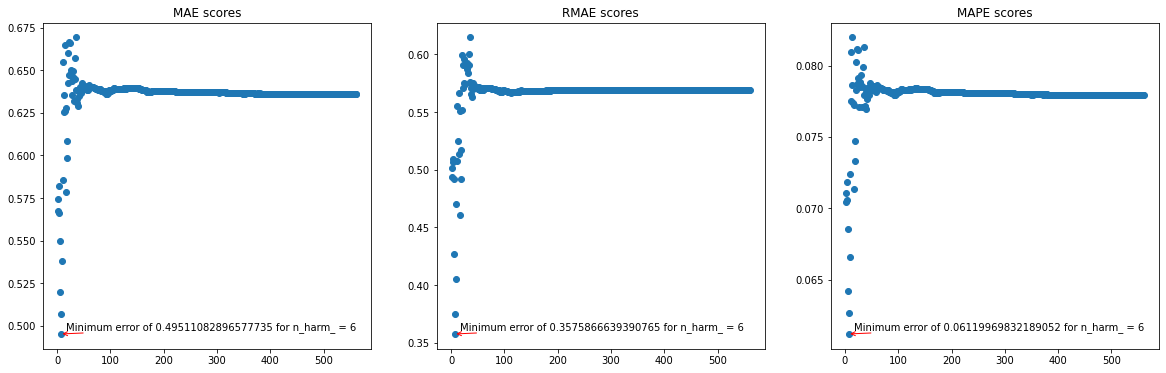

In [258]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
annotations = []
samples = list(range(1, int(decomposed.trend.size/2)))

ax1.scatter(samples, maes)
ax1.set_title('MAE scores')
t = ax1.text(np.argmin(maes), min(maes), f'Minimum error of {min(maes)} for n_harm_ = {np.argmin(maes)}')

adjust_text([t], arrowprops=dict(arrowstyle='->', color='red'), ax=ax1)

ax2.scatter(samples, rmaes)
ax2.set_title('RMAE scores')
t = ax2.text(np.argmin(rmaes), min(rmaes), f'Minimum error of {min(rmaes)} for n_harm_ = {np.argmin(rmaes)}')

adjust_text([t],  arrowprops=dict(arrowstyle='->', color='red'), ax=ax2)

ax3.scatter(samples, mapes)
ax3.set_title('MAPE scores')
t = ax3.text(np.argmin(mapes), min(mapes), f'Minimum error of {min(mapes)} for n_harm_ = {np.argmin(mapes)}')

adjust_text([t],arrowprops=dict(arrowstyle='->', color='red'), ax=ax3)

plt.show()

Thus, we choose a n_harm parameter of 6. 

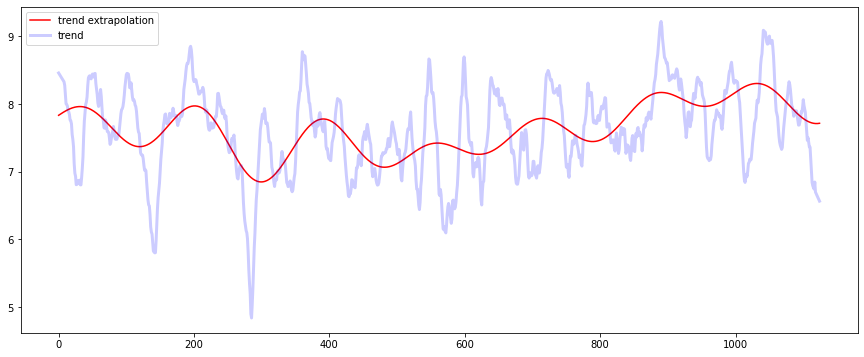

In [259]:
fig, ax = plt.subplots(figsize = (15,6))

trend_train = fourierExtrapolation(MA_train.trend, n_predict = 125, n_harm_ = 6)
plot_fourrier(trend_train, decomposed.trend, ax, 'trend')

plt.show()

Here is our are custom functions for forecasting

## Fitting an MA model 

In [62]:
MA_smoothed = Y_train_new.nretweets - pd.Series(trend, index = decomposed.seasonal.index)
MA_smoothed = MA_smoothed - decomposed.seasonal

In [82]:
import pmdarima as pm
model = pm.auto_arima(MA_smoothed, 
                      start_p=0, start_q=0, max_order=100, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3814.052, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3754.255, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3768.532, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3812.058, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3731.013, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3719.534, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3716.845, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3713.071, Time=0.18 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3714.746, Time=0.59 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3714.105, Time=0.42 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3711.074, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3714.848, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3712.749, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3712.107, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)

In [90]:
model = ARIMA(MA_smoothed, order = (0,0, 7), enforce_stationarity = True, missing = 'none')
MA_smooth = model.fit()
MA_smooth.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1125
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -1849.355
Date:                Tue, 03 May 2022   AIC                           3716.710
Time:                        10:11:12   BIC                           3761.940
Sample:                             0   HQIC                          3733.802
                               - 1125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.068      0.060      0.952      -0.130       0.138
ma.L1          0.1649      0.029      5.610      0.000       0.107       0.223
ma.L2          0.1362      0.030      4.605      0.000       0.078       0.194
ma.L3          0.1268      0.029      4.337      0.000       0.070       0.184
ma.L4          0.0970      0.027      3.543      0.000       0.043       0.151
ma.L5          0.1107      0.030      3.730      0.000       0.053       0.169
ma.L6          0.0584      0.029      1.985      0.047       0.001       0.116
ma.L7          0.0829      0.029      2.864      0.004       0.026       0.140
sigma2         1.5678      0.073     21.600      0.000       1.426       1.710
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.41
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.28
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

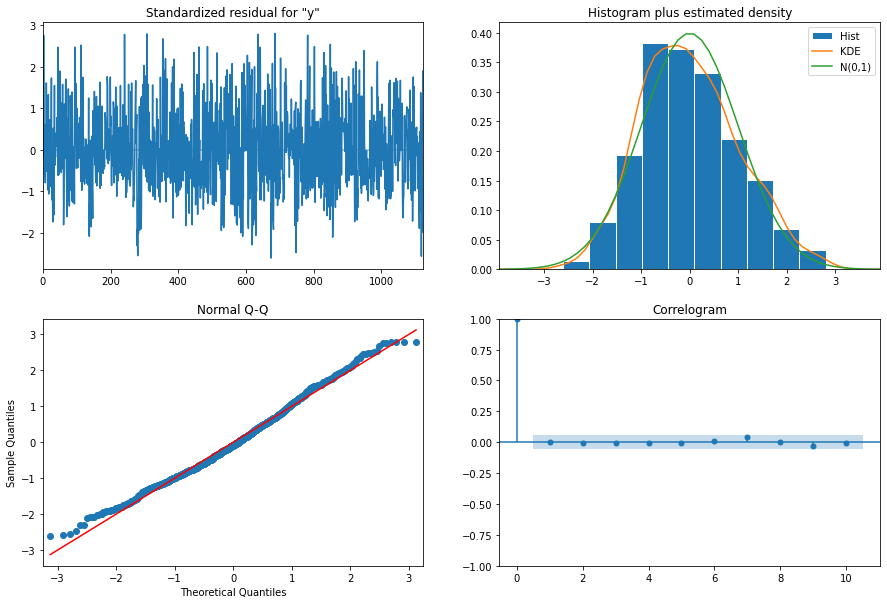

In [84]:
plt.rcParams['figure.figsize'] = [15, 10]

MA_smooth.plot_diagnostics()

plt.show()

We see from the KDE line at the top right, the QQ plot at the bottom left, and the ACF at the bottom right that the residuals are normally distributed. 

In [93]:
acorr_ljungbox(MA_smooth.resid)

,lb_stat,lb_pvalue
1,0.014717,0.903441
2,0.023313,0.988411
3,0.042124,0.997729
4,0.068232,0.999431
5,0.141075,0.999622
6,0.214116,0.999811
7,0.318092,0.999878
8,2.401438,0.966169
9,2.403258,0.983373
10,2.437497,0.991756


Holt-Winters

In [347]:
HW = ExponentialSmoothing(Y_train_new.nretweets, seasonal_periods = 2,
                                          damped_trend = True, seasonal = 'mul',missing = 'none', trend='mul').fit()

HW.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Dep. Variable:,nretweets,No. Observations:,1125
Model:,ExponentialSmoothing,SSE,1868.777
Optimized:,True,AIC,584.939
Trend:,Multiplicative,BIC,620.118
Seasonal:,Multiplicative,AICC,585.101
Seasonal Periods:,2,Date:,"Tue, 03 May 2022"
Box-Cox:,False,Time:,13:39:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1720821,alpha,True
smoothing_trend,0.000000,beta,True


In [362]:
acorr_ljungbox(HW.resid)

,lb_stat,lb_pvalue
1,2.078102,0.149426
2,2.354551,0.308117
3,2.491713,0.476791
4,2.710121,0.607445
5,2.975234,0.703804
6,4.209455,0.648355
7,4.244504,0.751224
8,6.161402,0.629158
9,10.919964,0.281235
10,13.507236,0.196677


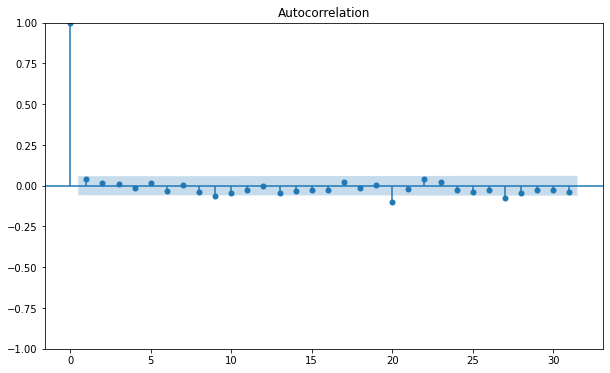

In [363]:
plt.rcParams['figure.figsize'] = [10, 6]
plot_acf(HW.resid)
plt.show()

### Dicky-Fuller Test

In [94]:
def dicky_fuller(time_series):
    dftest = adfuller(time_series)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [103]:
dicky_fuller(HW.fittedvalues)

Test Statistic                -5.726894e+00
p-value                        6.738776e-07
#Lags Used                     2.200000e+01
Number of Observations Used    1.102000e+03
Critical Value (1%)           -3.436298e+00
Critical Value (5%)           -2.864166e+00
Critical Value (10%)          -2.568168e+00
dtype: float64


In [95]:
dicky_fuller(MA_smooth.fittedvalues)

Test Statistic                -7.354324e+00
p-value                        9.871218e-11
#Lags Used                     1.800000e+01
Number of Observations Used    1.106000e+03
Critical Value (1%)           -3.436276e+00
Critical Value (5%)           -2.864157e+00
Critical Value (10%)          -2.568163e+00
dtype: float64


With 99% confidence, we fail to reject the null hypothesis that the series does not have a unit root, for both series. 

Let's compare the graphs

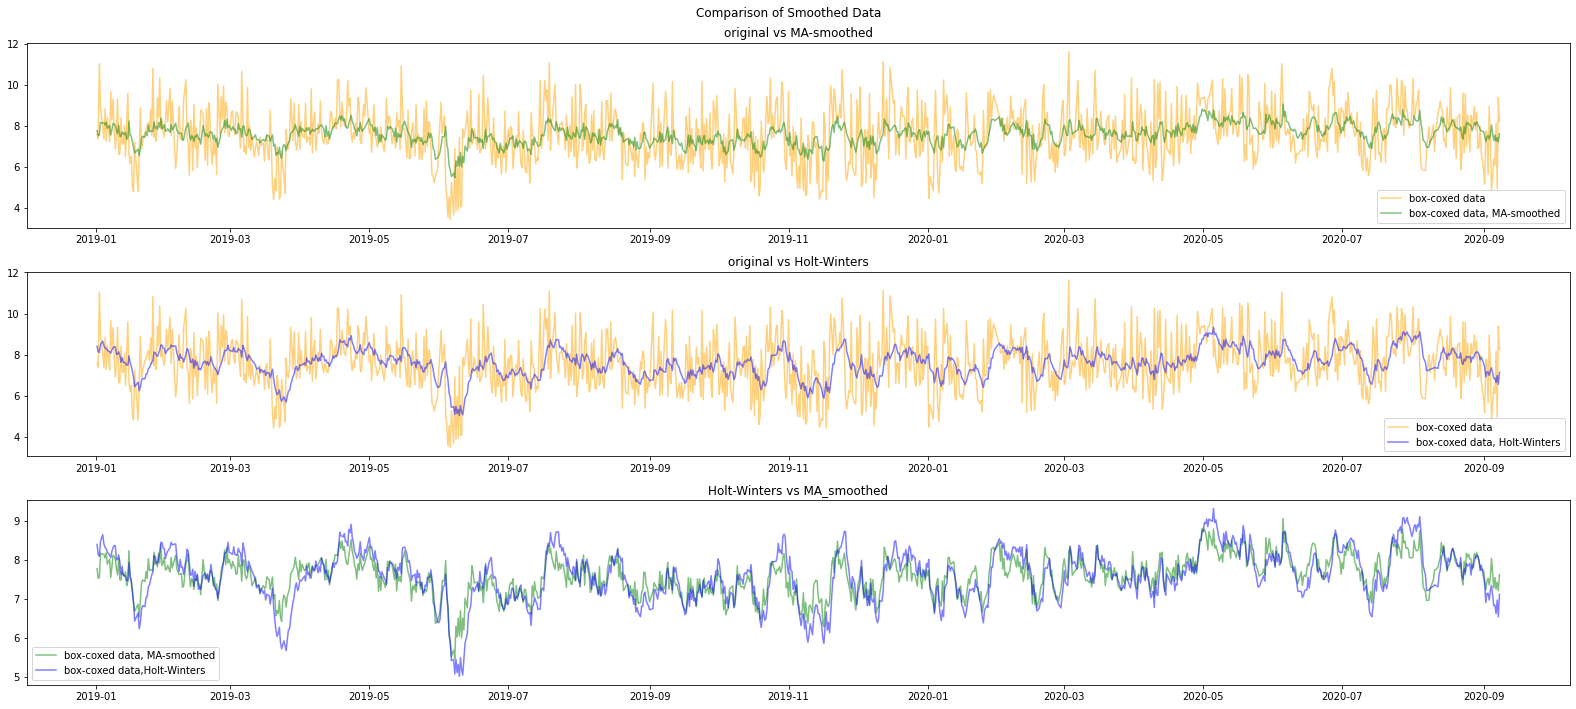

In [218]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[22,10])

fig.suptitle("Comparison of Smoothed Data")

ax1.set_title('original vs MA-smoothed')
ax1.plot(Y_train_new.nretweets, color = 'orange', alpha = .5, label = 'box-coxed data')
ax1.plot(MA_smooth.fittedvalues + add_trend_seasonality(), 
         color = 'green', alpha = .5, label = 'box-coxed data, MA-smoothed')
ax1.legend()

ax2.set_title('original vs Holt-Winters')
ax2.plot(Y_train_new.nretweets, color = 'orange', alpha = .5, label = 'box-coxed data')
ax2.plot(HW.fittedvalues, color = 'blue', 
         alpha = .5, label = 'box-coxed data, Holt-Winters')
ax2.legend()

ax3.set_title('Holt-Winters vs MA_smoothed')
ax3.plot(MA_smooth.fittedvalues + add_trend_seasonality(), 
         color = 'green', alpha = .5, label = 'box-coxed data, MA-smoothed')
ax3.plot(HW.fittedvalues, color = 'blue', 
         alpha = .5, label = 'box-coxed data,Holt-Winters')
ax3.legend()

fig.tight_layout()
plt.show()

Now let's perform a classical time series decomposition on this smoothed data. 

In [134]:
%matplotlib inline

def inverse_transformation(time_series, lambda_ = lambda_):
    return inv_boxcox(time_series, lambda_)

def print_all_tests(observed, pred, x = None):
    if x is not None: 
        print(f'Iteration: {x}')
    print(f'MAE: {MAE(observed, pred)}')
    print(f'RMAE: {RMAE(observed, pred)}')
    print(f'MAPE: {MAPE(observed, pred)}')

def transform(time_series, index, lambda_ = lambda_):
    return pd.Series(boxcox(time_series, lambda_), index = index)

def predict_MA(steps, cutoff, ax, ret = False):
    forecast_object = MA_smooth.get_forecast(steps = steps)
    mean, mean_se, mean_ci_lower, mean_ci_upper = np.hsplit(forecast_object.summary_frame().values, 4)

    index = Y_test.index[:steps]

    # Make as pandas series
    fc_series = pd.Series(mean.squeeze(), index=index)
    lower_series = pd.Series(mean_ci_lower.squeeze(), index=index)
    upper_series = pd.Series(mean_ci_upper.squeeze(), index=index)

    mean_se = pd.Series(mean_se.squeeze(), index=index)

    Y_train_new_ = pd.Series(Y_train_new.nretweets, index=Y_train_new.index)[cutoff:]

    # Plot
    ax.plot(Y_train_new_, label='training', alpha = .95)

    #Y_test_new = transform(time_series= Y_test, index = Y_test.index)[:steps]

    seasonal = pd.Series(fourierExtrapolation(decomposed.seasonal, 205)[-steps:], index = index)
    trend = pd.Series(fourierExtrapolation(decomposed.trend, 205, 6)[-steps:], index = index)

    box_cox_Y_test = pd.Series(boxcox(Y_test, lmbda = lambda_), index = index)

    ax.plot(box_cox_Y_test[:steps], label='actual', alpha = .5)
    
    ax.plot(fc_series + seasonal + trend, label='forecast', color = 'r', linestyle='dashed')


    ax.fill_between(lower_series.index, lower_series + seasonal + trend - mean_se, 
                     upper_series + seasonal + trend + mean_se,
                     color='k', alpha=.15, label = 'CI')

    #plt.fill_between(lower_series.index, fc_series + seasonal + trend, fc_series + seasonal + trend,
    #                 color='blue', alpha=.15, label = 'mean_se')

    ax.set_title('MA(0,0,7) Forecast vs Actuals')
    ax.legend(loc='upper left', fontsize=8)
    if ret == True: 
        return fc_series + seasonal + trend
    
def predict_HW(steps, ax, repetitions = 50, ret = False):
    box_cox_Y_test = pd.Series(boxcox(Y_test, lmbda = lambda_), index = Y_test.index)

    ax1.set_ylabel("Elon Musk Retweets amount (box-coxed)")
    ax1.set_xlabel("Time")
    #fig.suptitle("Predictions")
    simulations = HW.simulate(steps, repetitions=repetitions, error="mul", anchor= Y_train.size)
    forecast = pd.Series(HW.forecast(steps).values, index = Y_test.index)
    simulations.set_index(Y_test.index, inplace = True)

    ax.set_title('Holt-Winters Forecast vs Actual')
    ax.plot(Y_train_new.nretweets, color = 'blue', alpha = .5, label = 'box-coxed data')
    ax.plot(HW.fittedvalues, color = 'red',linestyle='dashed',  alpha = .5, label = 'box-coxed data, Holt-Winters')
    ax.plot(box_cox_Y_test, color = 'yellow', label = 'actual')
    ax.plot(forecast, color = 'r', label = 'Predicted')
    ax.plot(simulations, color = 'grey', alpha = .04)
    ax.legend()
    if ret == True: 
        return forecast

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


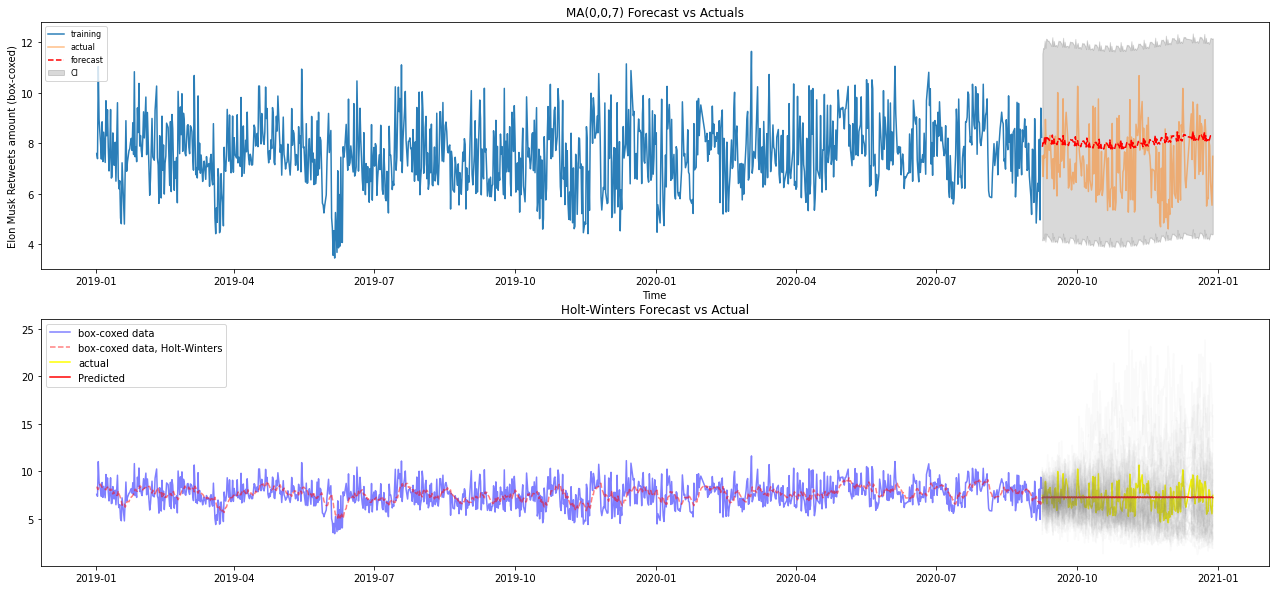

In [124]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[22,10])

#fig.suptitle("Model Forecasts")

MA_predictions = predict_MA(205, 0, ax = ax1, ret = True)

HW_predictions = predict_HW(205, ax = ax2, ret = True)

plt.show()

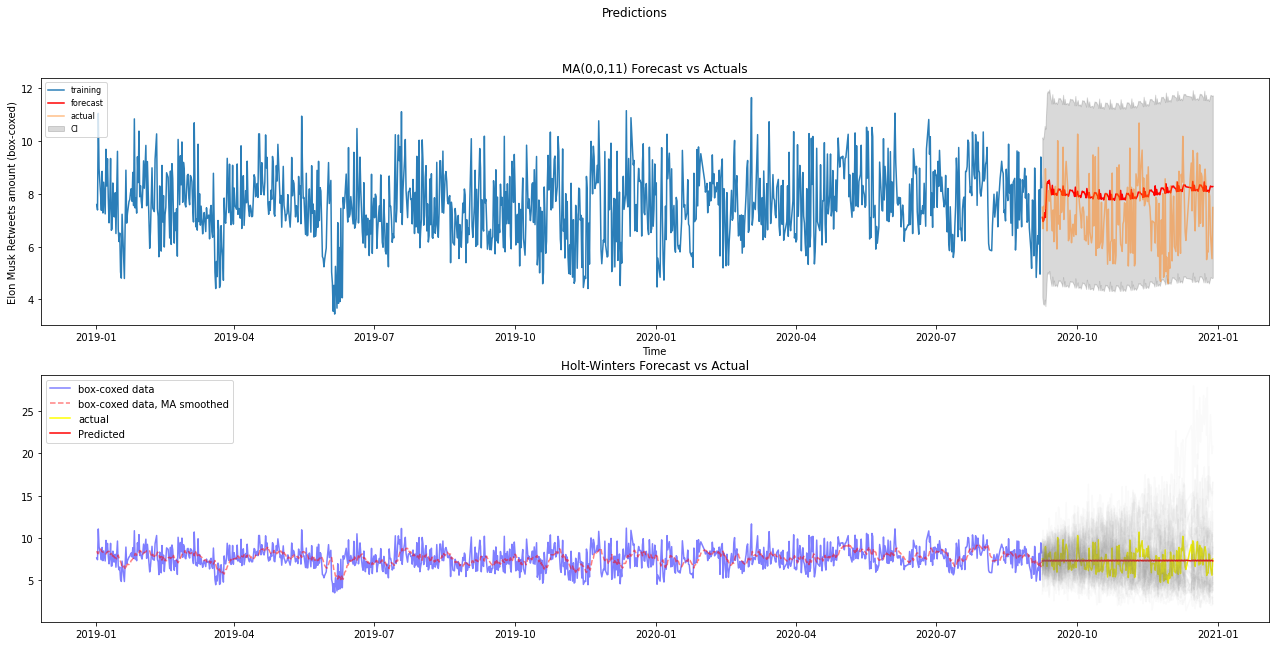

In [647]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[22,10])

fig.suptitle("Model Forecasts")

MA_predictions = predict_MA(205, 0, ax = ax1, ret = True)

HW_predictions = predict_HW(205, ax = ax2, ret = True)

plt.show()

In [118]:
box_cox_Y_test = pd.Series(boxcox(Y_test, lmbda = lambda_), index = Y_test.index)

In [659]:
original = MA_smooth.fittedvalues + add_trend_seasonality()

### Forecast errors

In [169]:
def return_all_tests(observed, pred):
    return (MAE_(observed, pred), RMAE(observed, pred), MAPE(observed, pred))

def MAE_(observed, pred):
    return mean_absolute_error(observed, pred)

def RMAE(observed, pred):
    return mean_squared_error(observed, pred)

def MAPE(observed, pred):
    return mean_absolute_percentage_error(observed, pred)

In [140]:
HW_predictions[:10].apply(lambda x: inverse_transformation(x))

2020-09-08 12:00:00    1983.504755
2020-09-09 00:00:00    2192.936894
2020-09-09 12:00:00    1983.871913
2020-09-10 00:00:00    2193.346404
2020-09-10 12:00:00    1984.235486
2020-09-11 00:00:00    2193.751915
2020-09-11 12:00:00    1984.595506
2020-09-12 00:00:00    2194.153465
2020-09-12 12:00:00    1984.952009
2020-09-13 00:00:00    2194.551092
dtype: float64

In [142]:
MAE, RMAE, MAPE = return_all_tests(HW_predictions[:10].apply(lambda x: inverse_transformation(x)), 
                box_cox_Y_test[:10].apply(lambda x: inverse_transformation(x)))

In [143]:
MAE

2392.416536039802

In [161]:
y = box_cox_Y_test[:steps].apply(lambda x: inverse_transformation(x))

In [162]:
x = HW_predictions[:steps].apply(lambda x: inverse_transformation(x))

In [172]:
lambda x: inverse_tranHW_predictions[:steps].values.flatten()

array([7.22660511])

In [320]:
HW_predictions[:10]

2020-09-08 12:00:00    7.226605
2020-09-09 00:00:00    7.317402
2020-09-09 12:00:00    7.226773
2020-09-10 00:00:00    7.317571
2020-09-10 12:00:00    7.226939
2020-09-11 00:00:00    7.317738
2020-09-11 12:00:00    7.227103
2020-09-12 00:00:00    7.317903
2020-09-12 12:00:00    7.227265
2020-09-13 00:00:00    7.318067
dtype: float64

In [326]:
ma_errs[:steps]

2019-01-01 12:00:00   -142.055786
2019-01-02 00:00:00   -176.160065
2019-01-02 12:00:00    -99.625595
2019-01-03 00:00:00   -167.228882
2019-01-04 00:00:00   -119.424988
dtype: float64

In [329]:
MA_predictions[:steps].values + ma_errs[:steps].values

array([-134.20512792, -168.14251072,  -91.68219026, -158.98830844,
       -111.49258133])

In [339]:
HW, MA_ = [],[]
for steps in [1, 5,10,20,205]:
    box_cox = box_cox_Y_test[:steps].apply(lambda x: inverse_transformation(x))
    HW_ = HW_predictions[:steps].apply(lambda x: inverse_transformation(x)).values + exp_errs[:steps].values
    MA = MA_predictions[:steps].apply(lambda x: inverse_transformation(x)).values + ma_errs[:steps].values
    HW.append([mean_absolute_error(HW_, box_cox), mean_squared_error(HW_, box_cox), 
               mean_absolute_percentage_error(HW_, box_cox), steps])
    MA_.append([mean_absolute_error(MA, box_cox), mean_squared_error(MA, box_cox), 
               mean_absolute_percentage_error(MA, box_cox), steps])

In [340]:
pd1 = pd.DataFrame(HW, columns = ['MAE', 'RMSE', 'MAPE', 'n_steps']).set_index('n_steps', drop=True)

In [342]:
pd2 = pd.DataFrame(MA_, columns = ['MAE', 'RMSE', 'MAPE', 'n_steps']).set_index('n_steps', drop=True)

In [343]:
pd1

,MAE,RMSE,MAPE
n_steps,,,
1,945.402075,8.937851e+05,0.556578
5,3059.236445,2.829763e+07,1.790547
10,2573.916194,1.683801e+07,1.474846
20,4227.501351,1.043778e+08,2.301845
205,4830.451245,1.351092e+08,3.900227


In [344]:
pd2

,MAE,RMSE,MAPE
n_steps,,,
1,1178.690583,1.389311e+06,0.308341
5,3794.314309,2.273500e+07,0.840586
10,2909.874269,1.470560e+07,0.595449
20,4668.872216,9.294285e+07,0.972562
205,5413.329251,1.193823e+08,1.222750


In [207]:
fig, (ax, ax2, ax3, ax4, ax5, ax6) = plt.subplots(3, 2, sharey=True)

ax.invert_xaxis()
ax.yaxis.tick_right()

pd1.plot(kind='barh', label='Holt-Winters', alpha = .1, ax=ax)
pd2.plot(kind='barh', label='MA (0,0,7)', alpha = .1 , ax=ax2)
ax1.legend()
ax2.legend()

plt.show()

TypeError: subplots() got multiple values for argument 'ncols'

In [120]:
for x in [1,5,10,20,205]:
    print(f'Step Size = {x}\n')
    model_forecast_errors(x)
    print('\n')

Step Size = 1

HW model predictions
MAE: 660.4952451816737
RMAE: 436253.9689075992
MAPE: 0.33299403168920955


MA model predictions
MAE: 1320.7463695455494
RMAE: 1744370.972667749
MAPE: 0.33312253709105105


Step Size = 5

HW model predictions
MAE: 2856.1956671098897
RMAE: 26775098.11121942
MAPE: 1.42644650684565


MA model predictions
MAE: 3887.4433768787117
RMAE: 22926222.633325905
MAPE: 0.834920461275356


Step Size = 10

HW model predictions
MAE: 2392.416536039802
RMAE: 15588958.679588586
MAPE: 1.173455919366622


MA model predictions
MAE: 3046.846468089475
RMAE: 15127048.74956328
MAPE: 0.6035711085599929


Step Size = 20

HW model predictions
MAE: 4189.768290836859
RMAE: 102616458.95786884
MAPE: 1.9806462576512647


MA model predictions
MAE: 4871.253075829462
RMAE: 93550446.15732786
MAPE: 0.9691157946555947


Step Size = 205

HW model predictions
MAE: 4807.9962273090705
RMAE: 130613688.27882326
MAPE: 2.2907030323531044


MA model predictions
MAE: 5634.482698826908
RMAE: 118464496.

In [242]:
ma_errs = np.array(MA_predicted_errors[205:].values.tolist() +  MA_predicted_errors[:205].values.tolist())

In [243]:
exp_errs = np.array(exp_predicted_erros[205:].values.tolist() + exp_predicted_erros[:205].values.tolist())

In [ ]:
exp_errs, ma_errs

In [235]:
MA_predicted_errors = pd.read_csv('Model/predicted_errors_MA.csv')

In [236]:
exp_predicted_erros = pd.read_csv('Model/predicted_errors_exp.csv')

In [701]:
exp_pred_errs = pd.Series(exp_predicted_erros.values.flatten(), index = df.index)

In [703]:
MA_pred_errs = pd.Series(MA_predicted_errors.values.flatten(), index = df.index)

In [213]:
ma_training_set = MA_smooth.fittedvalues + add_trend_seasonality()

In [219]:
hw_training_set = HW.fittedvalues

<AxesSubplot:>

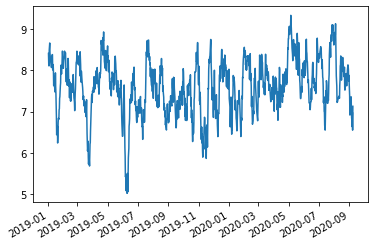

In [220]:
hw_training_set.plot()

In [230]:
ma_training_errors = Y_train_new.nretweets.apply(lambda x: inverse_transformation(x)) - ma_training_set.apply(lambda x: inverse_transformation(x))

In [229]:
hw_training_errors = Y_train_new.nretweets.apply(lambda x: inverse_transformation(x)) - hw_training_set.apply(lambda x: inverse_transformation(x))

In [233]:
ma_training_errors.to_frame().to_csv('MA_TRAINING_ERRORS.csv', index = False)

<AxesSubplot:>

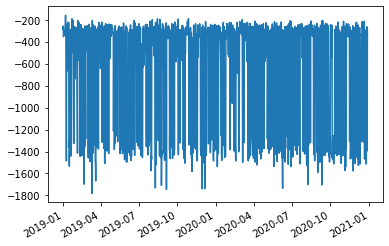

In [259]:
exp_errs.plot()

In [234]:
hw_training_errors.to_frame().to_csv('HW_TRAINING_ERRORS.csv', index = False)

In [228]:
ma_errors

2019-01-01 12:00:00      -708.454719
2019-01-02 00:00:00      -434.715766
2019-01-02 12:00:00    147129.577023
2019-01-03 00:00:00      7815.022064
2019-01-04 00:00:00      -991.531848
                           ...      
2020-09-06 00:00:00     -2288.680472
2020-09-06 12:00:00      3480.020845
2020-09-07 00:00:00     -2343.960141
2020-09-07 12:00:00     20373.590173
2020-09-08 00:00:00      2958.026149
Length: 1125, dtype: float64

In [227]:
hw_errors

2019-01-01 12:00:00     -4411.830049
2019-01-02 00:00:00     -3168.322558
2019-01-02 12:00:00    144722.221550
2019-01-03 00:00:00      5461.629725
2019-01-04 00:00:00     -5263.007767
                           ...      
2020-09-06 00:00:00      -728.255469
2020-09-06 12:00:00      4502.396605
2020-09-07 00:00:00     -1345.450893
2020-09-07 12:00:00     21395.800201
2020-09-08 00:00:00      4296.288724
Length: 1125, dtype: float64

<AxesSubplot:>

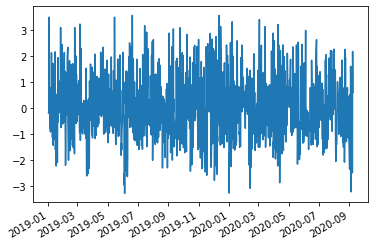

In [221]:
(Y_train_new.nretweets - ma_training_set).plot()

In [702]:
exp_pred_errs

2019-01-01 12:00:00   -0.070198
2019-01-02 00:00:00   -0.066757
2019-01-02 12:00:00   -0.073196
2019-01-03 00:00:00   -0.067608
2019-01-04 00:00:00   -0.067797
                         ...   
2020-12-26 00:00:00   -0.073453
2020-12-26 12:00:00   -0.069567
2020-12-27 00:00:00   -0.066387
2020-12-28 00:00:00   -0.065565
2020-12-28 12:00:00   -0.066397
Length: 1330, dtype: float64

# Modeling the time series with the LSTM-predicted errors 

In [281]:
np.max(ma_errs.values)

-39.95480346679688

In [251]:
ma_errs = pd.Series(boxcox(ma_errs.values.flatten(), lambda_), index = df.index)

ValueError: Data must be positive.

In [252]:
exp_errs = pd.Series(boxcox(exp_errs.values.flatten(), lambda_), index = df.index)

ValueError: Data must be positive.

In [247]:
exp_errs

2019-01-01 12:00:00    -284.906830
2019-01-02 00:00:00    -257.123199
2019-01-02 12:00:00    -353.370422
2019-01-03 00:00:00    -346.180511
2019-01-04 00:00:00    -287.869324
                          ...     
2020-12-26 00:00:00   -1513.124756
2020-12-26 12:00:00    -337.942352
2020-12-27 00:00:00    -262.545959
2020-12-28 00:00:00   -1394.003540
2020-12-28 12:00:00    -303.267609
Length: 1330, dtype: float64

In [250]:
boxcox([1, 2], lambda_)

array([0.        , 0.69000409])

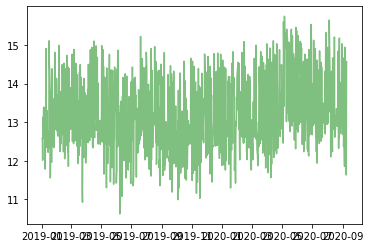

In [264]:
plt.plot(MA_smooth.fittedvalues + add_trend_seasonality() + boxcox(np.abs(ma_errs), lambda_)[:1125], 
         color = 'green', alpha = .5, label = 'box-coxed data, MA smoothed')

In [345]:
new_errs_exp = boxcox(np.abs(exp_errs), lambda_)

new_errs_ma = boxcox(np.abs(ma_errs), lambda_)

In [315]:
new_errs_ma = boxcox( ma_errs + abs(min(ma_errs)) + .1, lambda_)

In [314]:
new_errs_exp, new_errs_ma = boxcox( exp_errs + abs(min(exp_errs)) + .1, lambda_)

In [268]:
new_errs_ma - np.mean(Y_train_new.nretweets)

array([-2.81031646, -2.60897778, -3.14354951, ..., -2.54538972,
       -0.77131796, -2.61667585])

In [267]:
np.mean(Y_train_new.nretweets)

7.608790577946606

In [289]:
(MA_smooth.fittedvalues + add_trend_seasonality()).mean()

7.609257705149026

In [291]:
7.609257705149026 - new_errs_ma.mean()

1.9699703913895448

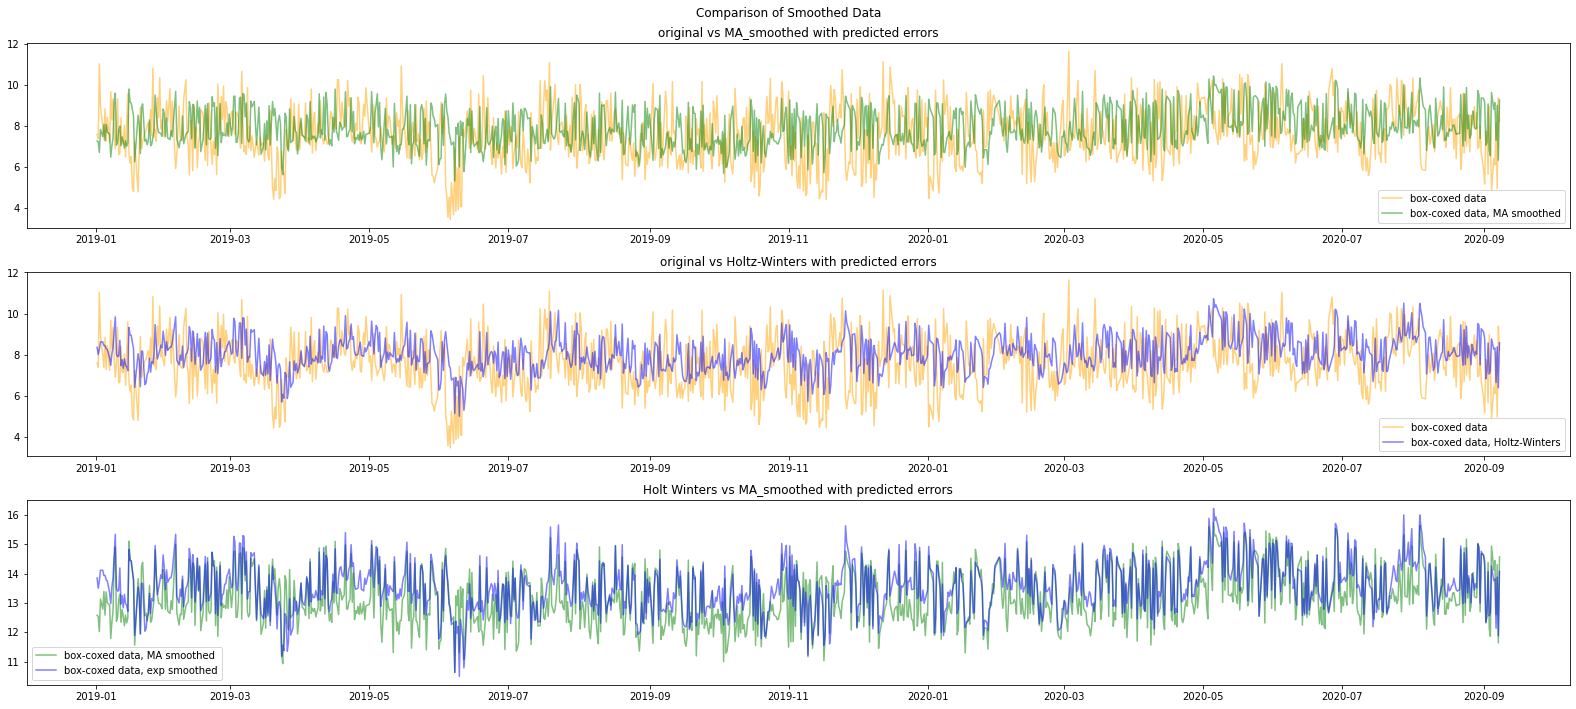

In [351]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[22,10])

fig.suptitle("Comparison of Smoothed Data")

ax1.set_title('original vs MA_smoothed with predicted errors')
ax1.plot(Y_train_new.nretweets, color = 'orange', alpha = .5, label = 'box-coxed data')
ax1.plot(np.abs(MA_smooth.fittedvalues + add_trend_seasonality()) + (new_errs_ma + -5.3 )[:1125], 
         color = 'green', alpha = .5, label = 'box-coxed data, MA smoothed')
ax1.legend()

ax2.set_title('original vs Holtz-Winters with predicted errors')
ax2.plot(Y_train_new.nretweets, color = 'orange', alpha = .5, label = 'box-coxed data')
ax2.plot(np.abs(HW.fittedvalues) + boxcox(np.abs(exp_errs), lambda_)[:1125] - 5.5, color = 'blue', 
         alpha = .5, label = 'box-coxed data, Holtz-Winters')
ax2.legend()

ax3.set_title('Holt Winters vs MA_smoothed with predicted errors')
ax3.plot(MA_smooth.fittedvalues + add_trend_seasonality() + boxcox(np.abs(ma_errs), lambda_)[:1125], 
         color = 'green', alpha = .5, label = 'box-coxed data, MA smoothed')
ax3.plot(HW.fittedvalues + boxcox(np.abs(exp_errs), lambda_)[:1125], color = 'blue', 
         alpha = .5, label = 'box-coxed data, exp smoothed')
ax3.legend()

fig.tight_layout()
plt.show()

In [260]:
def predict_MA_w_errors(steps, cutoff, ax, ret = False):
    forecast_object = MA_smooth.get_forecast(steps = steps)
    mean, mean_se, mean_ci_lower, mean_ci_upper = np.hsplit(forecast_object.summary_frame().values, 4)

    index = Y_test.index[:steps]

    # Make as pandas series
    fc_series = pd.Series(mean.squeeze(), index=index)
    lower_series = pd.Series(mean_ci_lower.squeeze(), index=index)
    upper_series = pd.Series(mean_ci_upper.squeeze(), index=index)

    mean_se = pd.Series(mean_se.squeeze(), index=index)

    Y_train_new_ = pd.Series(Y_train_new.nretweets, index=Y_train_new.index)[cutoff:]

    # Plot
    ax.plot(Y_train_new_, label='training', alpha = .95)

    #Y_test_new = transform(time_series= Y_test, index = Y_test.index)[:steps]

    seasonal = pd.Series(fourierExtrapolation(decomposed.seasonal, 205)[-steps:], index = index)
    trend = pd.Series(fourierExtrapolation(decomposed.trend, 205, 6)[-steps:], index = index)

    ax.plot(fc_series + seasonal + trend + MA_pred_errs[1125:], label='forecast', color = 'r')

    box_cox_Y_test = pd.Series(boxcox(Y_test, lmbda = lambda_), index = index)

    ax.plot(box_cox_Y_test[:steps], label='actual', alpha = .5)


    ax.fill_between(lower_series.index, lower_series + seasonal + trend - mean_se, 
                     upper_series + seasonal + trend + mean_se,
                     color='k', alpha=.15, label = 'CI')

    #plt.fill_between(lower_series.index, fc_series + seasonal + trend, fc_series + seasonal + trend,
    #                 color='blue', alpha=.15, label = 'mean_se')

    ax.set_title('MA(0,0,11) Forecast vs Actuals')
    ax.legend(loc='upper left', fontsize=8)
    if ret == True: 
        return fc_series + seasonal + trend + MA_pred_errs[1125:]
    
def predict_HW_w_errors(steps, ax, repetitions = 50, ret = False):
    box_cox_Y_test = pd.Series(boxcox(Y_test, lmbda = lambda_), index = Y_test.index)

    ax1.set_ylabel("Elon Musk Retweets amount (box-coxed)")
    ax1.set_xlabel("Time")
    fig.suptitle("Predictions")
    simulations = HW.simulate(steps, repetitions=repetitions, error="mul", anchor= Y_train.size)
    forecast = pd.Series(HW.forecast(steps).values, index = Y_test.index)
    simulations.set_index(Y_test.index, inplace = True)

    ax.set_title('Holt-Winters Forecast vs Actual')
    ax.plot(Y_train_new.nretweets, color = 'blue', alpha = .5, label = 'box-coxed data')
    ax.plot(HW.fittedvalues, color = 'red',linestyle='dashed',  alpha = .5, label = 'box-coxed data, MA smoothed')
    ax.plot(box_cox_Y_test, color = 'yellow', label = 'actual')
    ax.plot(forecast + exp_pred_errs[1125:], color = 'r', label = 'Predicted')
    ax.plot(simulations, color = 'grey', alpha = .04)
    ax.legend()
    if ret == True: 
        return forecast + exp_pred_errs[1125:]

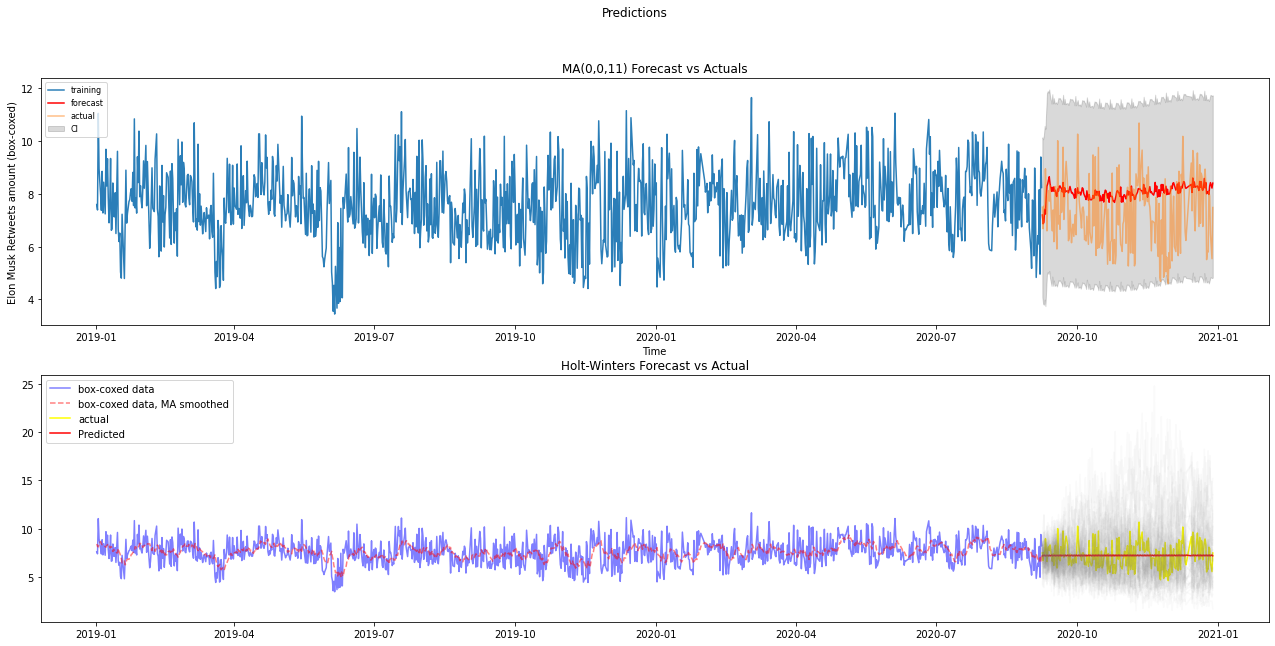

In [715]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[22,10])

fig.suptitle("Model Forecasts")

MA_predictions_errs = predict_MA_w_errors(205, 0, ax = ax1, ret = True)

HW_predictions_errs = predict_HW_w_errors(205, ax = ax2, ret = True)

plt.show()

In [716]:
def model_forecast_errors(steps):
    print('HW model predictions')
    print_all_tests(exp_errs[:steps], 
                box_cox_Y_test[:steps].apply(lambda x: inverse_transformation(x)))
    print('\n')
    print('MA model predictions')
    print_all_tests(ma_errs[:steps], 
                box_cox_Y_test[:steps].apply(lambda x: inverse_transformation(x)))
    
for x in [1,5,10,20,205]:
    print(f'Step Size = {x}\n')
    model_forecast_errors(x)
    print('\n')

Step Size = 1

HW model predictions
MAE: 802.3509039502501
RMAE: 643766.9730697834
MAPE: 0.4356698057579221


MA model predictions
MAE: 734.9903305866746
RMAE: 540210.7860559092
MAPE: 0.3850113188858538


Step Size = 5

HW model predictions
MAE: 2938.251903533342
RMAE: 27494269.593982734
MAPE: 1.585174477769006


MA model predictions
MAE: 2768.3092755182633
RMAE: 26800793.54801392
MAPE: 1.4675311446085666


Step Size = 10

HW model predictions
MAE: 2480.1131710828313
RMAE: 16195149.103602156
MAPE: 1.3119494065520174


MA model predictions
MAE: 3203.539753087764
RMAE: 22095524.738295726
MAPE: 0.9731226351080776


Step Size = 20

HW model predictions
MAE: 4235.189520358113
RMAE: 103726409.98121853
MAPE: 2.1632190029171277


MA model predictions
MAE: 4897.3258008416215
RMAE: 94066527.35508299
MAPE: 1.085141494387111


Step Size = 205

HW model predictions
MAE: 4803.909576071715
RMAE: 131678981.00657739
MAPE: 2.466445428239047


MA model predictions
MAE: 5524.551100621426
RMAE: 114313626.5